# Rank position clicked on and Time To First Click (TTFC)

This notebook builds upon `search-metrics/clicks-rank/clicks_rank_amethod.ipynb`.

Its objective is to compute:
- Distribution of ranking positions clicked on,
- Scatterplots for Avg. rank position clicked on vs Time To First Click (TTFC), both at the search and session levels.
The notebook generates the data to compute graphs with and without segmentation by access method (desktop, mobile web).

TTFC (at the search-level) is computed for tuple `t` (a given search) as

> `TTFC(t) = timestamp of first click - session_start = timestamp of first click - t.timestamp`

For the avg. ranking possition at the search-level the same logic as in `search-metrics/clicks-rank/clicks_rank_amethod.ipynb` was used.

Note: for some tuples `t` in `dqcd`, some clicks from `t.clicks` have a pageid that does not appear in `t.hits` and thus get position 0 (because of how pyspark array_position is implemented). Taking these into account, clicks that were mapped to position 0 were filtered out from the scatterplots but not from the distribution so that one can quantify them.

## Create spark session

In [1]:
import os, sys
import re, math, pprint

import findspark
findspark.init('/usr/lib/spark2')
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, Window
import wmfdata.spark as wmfspark

## defining the spark session
spark_config = {}
spark = wmfspark.get_session(
    app_name='Pyspark notebook | bscarone (WMF)', 
    type='regular'
#     extra_settings=spark_config
)
spark

You are using wmfdata v1.3.2, but v1.4.0 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md
PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


PYSPARK_PYTHON=/usr/lib/anaconda-wmf/bin/python3


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark2/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/20 23:43:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/10/20 23:43:25 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
22/10/20 23:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/20 23:43:39 WARN 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [3]:
# import function to retrive access_method
spark.sql("ADD JAR /srv/deployment/analytics/refinery/artifacts/refinery-hive-shaded.jar").show()
spark.sql("CREATE TEMPORARY FUNCTION get_access_method as 'org.wikimedia.analytics.refinery.hive.GetAccessMethodUDF'")

+------+
|result|
+------+
|     0|
+------+



DataFrame[]

In [4]:
# compute ttfirst, i.e. time to first click
# given by c[0].timesyamp - search_start (see in main function why session_start = min timestamp from all the searches within a session, is wrong)
# where search_start is the t.timestamp where t in dqcd 
# by def. clicks != {} always holds
@F.udf(returnType=T.IntegerType())
def TTFClick(clicks, search_start):
    # sort clicks asc by timestamp 
    clicks.sort(key=lambda x: x.timestamp)
    ttfc = clicks[0]["timestamp"] - search_start
    return ttfc

In [5]:
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def FilterRank0(click_positions):
    # eliminate entries that have value 0 
    return list(filter((lambda x : x != 0),click_positions))

In [6]:
# computes the avg rank and the TTFC from each tuple from the table  
def tuple_avg_rank_ttfc_by_amethod(year, month, day_start, day_end): # removed access_method (included in plot function)
    # compute access_method
    q_amethod = f'''
        WITH query_clicks_daily_aux AS(
            SELECT session_id, dqcd.hits, clicks, http.request_headers["user-agent"] as user_agent,
            regexp_extract(clicks[0].referer,":\/\/[www.]?([\-a-zA-Z0-9.]+)",1) as uri_host, dqcd.timestamp as timestamp
            FROM event.mediawiki_cirrussearch_request emcr INNER JOIN discovery.query_clicks_daily dqcd
                ON  emcr.search_id = dqcd.request_set_token
            WHERE 
                dqcd.year = {year}  AND dqcd.month = {month} AND dqcd.day BETWEEN {day_start} and {day_end} 
                AND emcr.year = {year}  AND emcr.month = {month} AND emcr.day BETWEEN {day_start} and {day_end} 
        )
        SELECT session_id, hits, clicks, get_access_method(uri_host, user_agent) as access_method, timestamp
        FROM query_clicks_daily_aux
    '''
    df_amethod = spark.sql(q_amethod)#.filter(F.col("access_method")==access_method)
    
    # I cannot collect clicks since the `hits' array differs accorss searches within a session
    # I am actually operating at the search-within-session level
    # What I can do, is take the avg accross all searches within a session
    # But in that case TTFC is meaningless, since I am using 
    # session_start = start from 1st search and first click from multiple searches within the session
    # I should use t.timestamp = start from search and first click from search to compute TTFC_search
    # After this I can take the avg accross sessions (avg accross al searches from a session)... see below

    # compute avg. rank per search within a session (per tuple from dqcd)
    # https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.array_position.html
    # array_position: Locates the position of the first occurrence of the given value in the given array. 
    # Returns null if either of the arguments are null.
    # The position is not zero based, but 1 based index. Returns 0 if the given value could not be found in the array.
    # For some tuples in `dqcd’, some clicks from `dqcd.clicks' have a pageid that does not appear in `dqcd.hits’
    
    # filter 0-rank clicks before computing avg. rank
    df_avgrank_amethod = df_amethod.withColumn(
            'click_positions', 
             F.expr('transform(clicks.pageid, click_page_id -> array_position(hits.pageid, click_page_id))')
        ).withColumn(
            'click_positions_filtered', FilterRank0(F.col('click_positions'))
        ).withColumn(
            'sum_rank', F.expr('aggregate(click_positions_filtered, cast(0 as float), (acc, val) -> acc + cast(val as float))')
        ).withColumn(
            'avg_rank',
            F.col('sum_rank') / F.size(F.col('click_positions_filtered'))
        ).drop('sum_rank')
    

    # [TODO] count % of 0-rank clicks
    
    # compute TTFClick
    df_avgrank_ttfc_amethod = df_avgrank_amethod.withColumn('ttfc', TTFClick(F.col("clicks"),F.col("timestamp")))
    
    # df_avgrank_ttfc_amethod.printSchema() # [debug]
    # df_avgrank_ttfc_amethod.select("access_method","timestamp","avg_rank","ttfc").show(2,False) # [debug]
    
    # avg accross all searches from a session
    df_avgrank_ttfc_amethod_gbysession = df_avgrank_ttfc_amethod.groupBy("session_id","access_method")\
                            .agg(F.mean("avg_rank").alias("avg_rank_session"),F.mean("ttfc").alias("avg_ttfc_session"))
    
    # df_avgrank_ttfc_amethod_gbysession.printSchema() # [debug]
        
    # write data to hdfs
    today = datetime.date.today()
    df_avgrank_ttfc_amethod.write.mode("overwrite").parquet(f'''clicks-rank/df_sessionid_hits_clicks_access_method_timestamp_click_positions_searchavgrank_searchttfc_{day_start}-{day_end}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')

    df_avgrank_ttfc_amethod_gbysession.write.mode("overwrite").parquet(f'''clicks-rank/df_sessionid_access_method__timestamp_click_positions_sessionavgrank_sessionavgttfc_{day_start}-{day_end}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')

    return df_avgrank_ttfc_amethod,df_avgrank_ttfc_amethod_gbysession
    

In [ ]:
df_avgrank_ttfc_amethod,df_avgrank_ttfc_amethod_gbysession = tuple_avg_rank_ttfc_by_amethod(2022,10,4,10)

In [ ]:
df_avgrank_ttfc_amethod.printSchema()

In [ ]:
df_avgrank_ttfc_amethod_gbysession.printSchema()

In [ ]:
df_avgrank_ttfc_amethod_f = df_avgrank_ttfc_amethod.select("ttfc","avg_rank","access_method")

In [ ]:
# check why I am getting avg_rank == 0 and they are not the majority (i.e. presumably not the first position in the ranking)
df_avgrank_ttfc_amethod.select("click_positions","avg_rank").where(F.col("avg_rank")<1).show(10,False)

## Graphs

In [4]:
def plot_scatterplot_by_amethod(df,x_var,y_var,x_label,y_label,x_unit,y_unit,access_method,year,month,day_start,day_end,alpha,figsize,use_log,zoomed):
    if access_method != "all":
        df = df.select(F.col(x_var),F.col(y_var)).where(F.col("access_method")==access_method)
    df.toPandas().plot.scatter(x=x_var, y=y_var, alpha=alpha, figsize=figsize, loglog=use_log)
    # format plot
    plt.title(f'''{x_label} vs {y_label} - {access_method} on {day_start}-{day_end}/{month}/{year} - loglog={use_log}''', fontsize=16) # took +6 out
    if x_unit == "":
        plt.xlabel(f'''{x_label}''', fontsize=14) # adjust units
    else:
        plt.xlabel(f'''{x_label} (in {x_unit})''', fontsize=14) # adjust units
    if y_unit == "":
        plt.ylabel(f'''{y_label}''', fontsize=14) # adjust units
    else:
        plt.ylabel(f'''{y_label} (in {y_unit})''', fontsize=14) # adjust units
    if not use_log:
        plt.ylim(ymin=0)
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, 21+1, 1.0), fontsize=14) # paramterize according to values of df_avgrank_ttfc_amethod.avg_rank
    
    # save plot
    filepath = f'/home/bscarone/search-metrics/clicks-rank/outputs/extensions/scatterplot_{x_var}_{y_var}_{access_method}_{day_start}-{day_end}{month}{year}'
    if use_log:
        filepath = filepath + "_loglog"
    if zoomed:
        filepath = filepath + "_zoomed"
    filepath = filepath + ".png"
    plt.savefig(filepath)

In [6]:
# read data from hdfs
df_avgrank_ttfc_amethod_gbysession = spark.read.parquet('clicks-rank/df_sessionid_access_method__timestamp_click_positions_sessionavgrank_sessionavgttfc_4-10102022_r20102022.parquet')

In [ ]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)","TTFC (search-level)","seconds","","all",2022,10,4,10,0.3,(20,10),False,False)

In [ ]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)","TTFC (search-level)","seconds","","desktop",2022,10,4,10,0.3,(20,10),False,False)

In [ ]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_f,"avg_rank","ttfc","Avg. rank clicked on (search-level)","TTFC (search-level)","seconds","","mobile web",2022,10,4,10,0.3,(20,10),False,False)

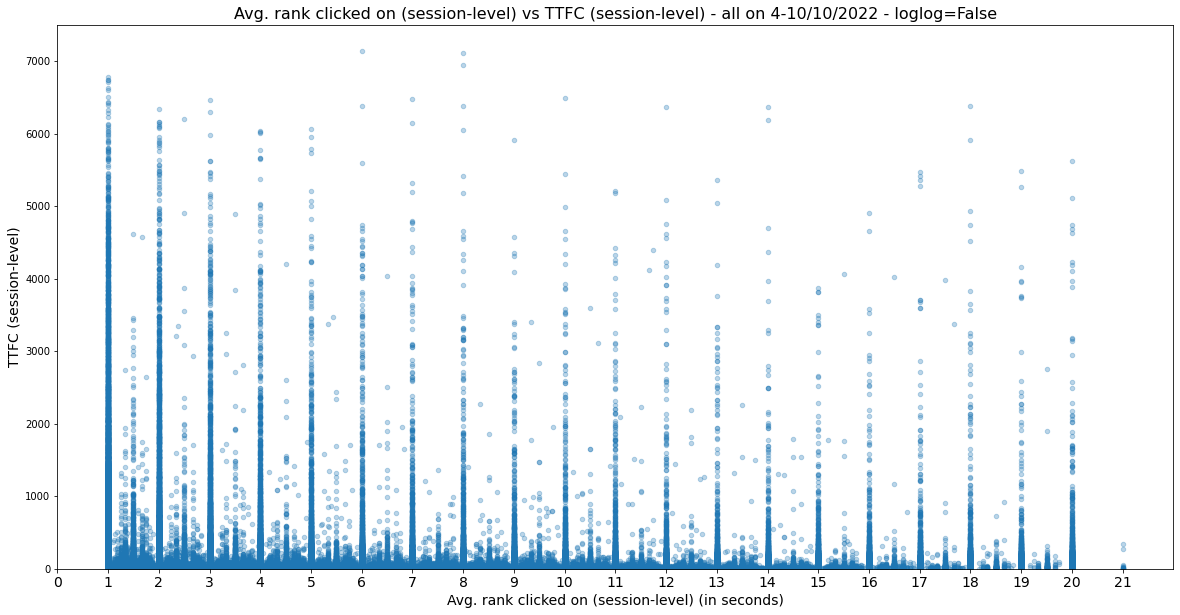

In [7]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_gbysession,"avg_rank_session","avg_ttfc_session","Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","","all",2022,10,4,10,0.3,(20,10),False,False)

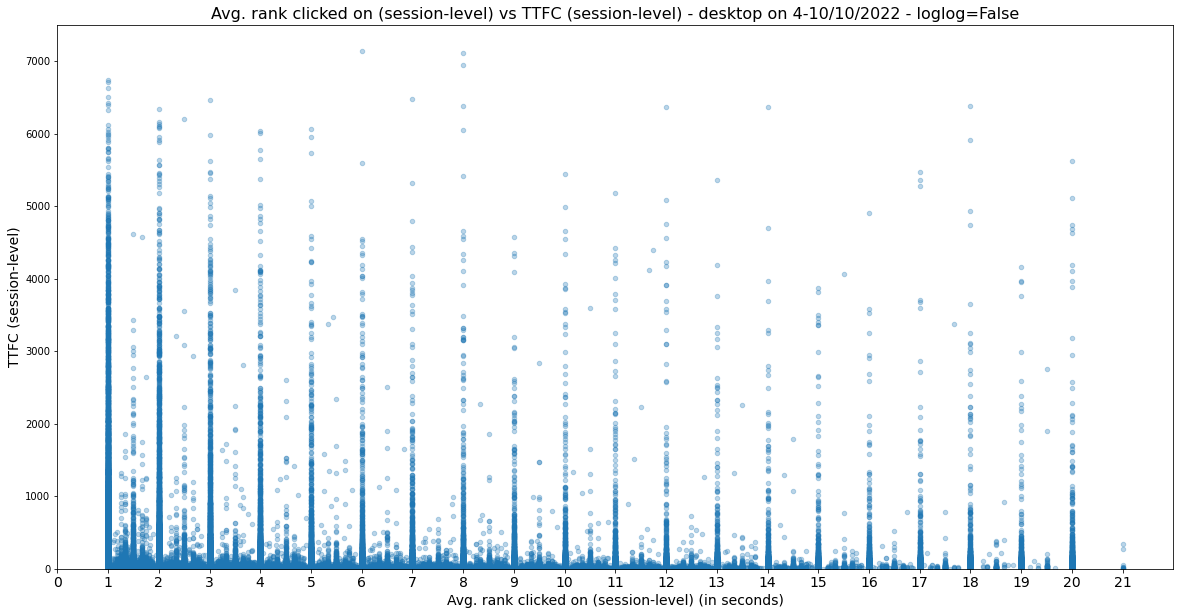

In [8]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_gbysession,"avg_rank_session","avg_ttfc_session","Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","","desktop",2022,10,4,10,0.3,(20,10),False,False)

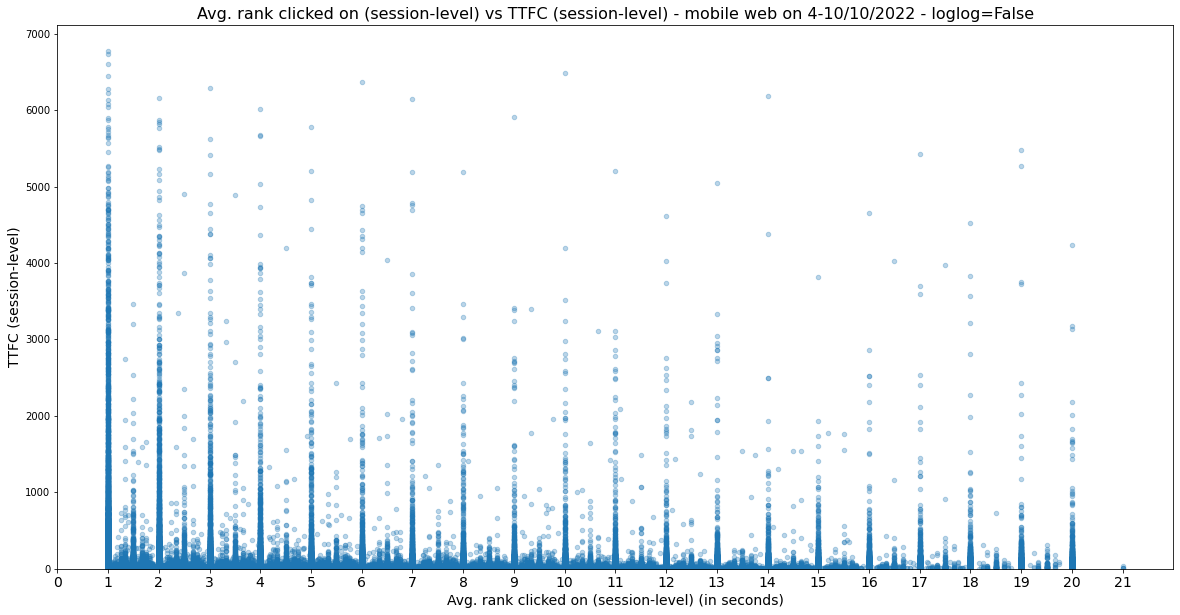

In [9]:
plot_scatterplot_by_amethod(df_avgrank_ttfc_amethod_gbysession,"avg_rank_session","avg_ttfc_session","Avg. rank clicked on (session-level)","TTFC (session-level)","seconds","","mobile web",2022,10,4,10,0.3,(20,10),False,False)

## Plot rank position -> % of clicks with rank pos.

In [ ]:
# se example histograms of dwell time with % of total in y'axis
# explode click_positions and use the same logic (do not use the filtered version to get the % of 0-rank clicks)

### Data generation

In [11]:
# example read: df_dw = spark.read.parquet('dwell-time/df_sessionid_amethod_nonempty_dwelltimes_4-1072022_r182022.parquet')
df_avgrank_ttfc_amethod = spark.read.parquet('clicks-rank/df_sessionid_hits_clicks_access_method_timestamp_click_positions_searchavgrank_searchttfc_4-10102022_r20102022.parquet')

In [8]:
df_avgrank_ttfc_amethod.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- index: string (nullable = true)
 |    |    |-- pageid: integer (nullable = true)
 |    |    |-- score: float (nullable = true)
 |    |    |-- profilename: string (nullable = true)
 |-- clicks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- pageid: integer (nullable = true)
 |    |    |-- timestamp: long (nullable = true)
 |    |    |-- referer: string (nullable = true)
 |-- access_method: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- click_positions: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- click_positions_filtered: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- avg_rank: double (nullable = true)
 |-- ttfc: integer (nullable = true)



In [16]:
df_click_pos_amethod = df_avgrank_ttfc_amethod.select("click_positions","access_method")

In [ ]:
df_click_pos_amethod.show(5,False)

In [17]:
# df_amethod_2 = df_amethod.withColumn("clicks", F.explode("clicks"))
df_click_pos_amethod_exp = df_click_pos_amethod.withColumn("click_position", F.explode("click_positions")).drop("click_positions")
df_click_pos_amethod_exp.show(5,False)

+-------------+--------------+
|access_method|click_position|
+-------------+--------------+
|desktop      |1             |
|desktop      |1             |
|desktop      |1             |
|mobile web   |2             |
|desktop      |1             |
+-------------+--------------+
only showing top 5 rows



In [22]:
def plot_barh(df,x_var,y_var,x_label,y_label,access_method,year,month,day_start,day_end,figsize):
    # if access_method != "all":
    #     df = df.select(F.col(x_var),F.col(y_var)).where(F.col("access_method")==access_method)
    pd_df = df.toPandas()
    pd_df.sort_values([x_var], inplace=True, ascending=False)
    pd_df.plot.barh(x=x_var, y=y_var, figsize=figsize)
    
    # title is partially hardcoded
    plt.title(f"Distribution of ranking positions clicked on - {access_method} on {day_start}-{day_end}/{month}/{year}",fontsize=16)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'''/home/bscarone/search-metrics/clicks-rank/outputs/extensions/barh_{x_var}_{y_var}_{access_method}_{day_start}-{day_end}{month}{year}.png''')


In [13]:
def compute_distr_click_positions(df_click_pos_amethod_exp, access_method):
    if access_method != "all":
        df_click_pos_amethod_exp = df_click_pos_amethod_exp.select("*").where(F.col("access_method")==access_method)
    
    total_clicks = df_click_pos_amethod_exp.count()
    print(f'total_clicks={total_clicks}')
    df_click_pos_exp_count = df_click_pos_amethod_exp.select("click_position").groupby("click_position").count()
    # compute percentages
    df_click_pos_exp_count = df_click_pos_exp_count.withColumn('percentage_of_total',(F.col("count")/total_clicks)*100)
    return df_click_pos_exp_count

In [18]:
df_distr_click_pos_all = compute_distr_click_positions(df_click_pos_amethod_exp, "all")

[Stage 6:=================================================>       (13 + 2) / 15]

total_clicks=5475467


In [19]:
df_distr_click_pos_all.show(22,False)

+--------------+-------+--------------------+
|click_position|count  |percentage_of_total |
+--------------+-------+--------------------+
|8             |53050  |0.9688671304201084  |
|6             |87144  |1.591535479987369   |
|4             |186876 |3.412969158612407   |
|15            |17365  |0.3171418985814361  |
|0             |56093  |1.02444229871169    |
|17            |14425  |0.26344784837530755 |
|11            |30030  |0.5484463699625987  |
|10            |34908  |0.6375346614270527  |
|16            |15896  |0.2903131367607548  |
|9             |42379  |0.7739796441107215  |
|20            |15589  |0.2847063090691625  |
|7             |65770  |1.201176082332338   |
|2             |743168 |13.57268704203678   |
|12            |25390  |0.46370473970530734 |
|1             |3566940|65.1440324633497    |
|19            |13722  |0.2506087608600326  |
|13            |22085  |0.40334459142937035 |
|21            |35     |6.392148834062921E-4|
|3             |328699 |6.00312265

In [18]:
df_distr_click_pos_all.printSchema()

root
 |-- click_position: long (nullable = true)
 |-- count: long (nullable = false)
 |-- percentage_of_total: double (nullable = true)



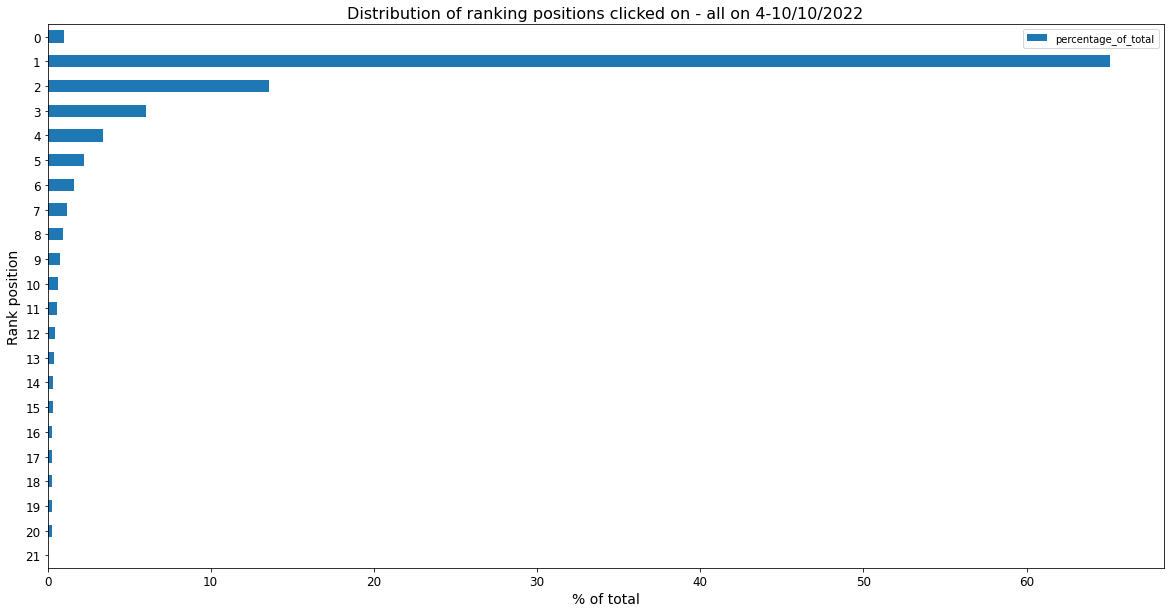

In [19]:
plot_barh(df_distr_click_pos_all,"click_position","percentage_of_total","% of total","Rank position","all",2022,10,4,10,(20,10))

In [20]:
df_distr_click_pos_desktop = compute_distr_click_positions(df_click_pos_amethod_exp, "desktop")

total_clicks=3030820


In [21]:
df_distr_click_pos_desktop.show(22,False)

+--------------+-------+--------------------+
|click_position|count  |percentage_of_total |
+--------------+-------+--------------------+
|8             |23304  |0.7689008255191665  |
|6             |40203  |1.326472703756739   |
|4             |95896  |3.164028216786216   |
|15            |7089   |0.23389709715522533 |
|0             |35031  |1.1558258161157706  |
|17            |5841   |0.19272012194719582 |
|11            |12482  |0.41183574082261565 |
|10            |15156  |0.5000626893052046  |
|16            |6498   |0.2143974237994998  |
|9             |18437  |0.6083172210820834  |
|20            |7158   |0.23617370876528465 |
|7             |29769  |0.982209435070377   |
|2             |418130 |13.795936413247901  |
|12            |10546  |0.34795863825631346 |
|1             |2039830|67.30290812387408   |
|19            |5779   |0.19067447093525844 |
|13            |8934   |0.294771711945942   |
|21            |24     |7.918649078467214E-4|
|3             |177612 |5.86019625

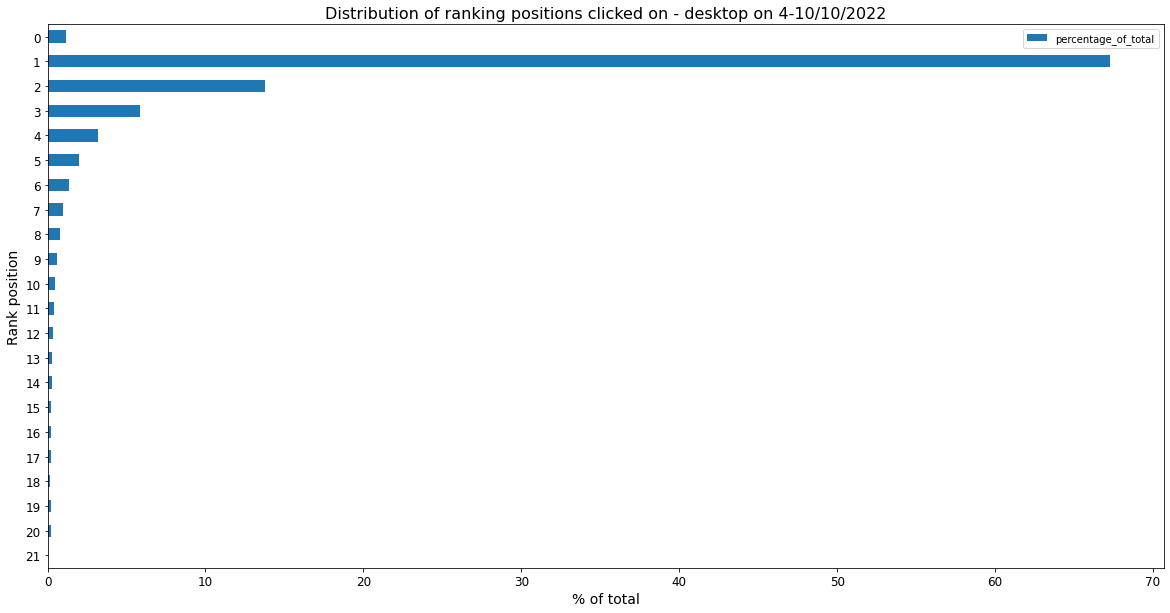

In [21]:
plot_barh(df_distr_click_pos_desktop,"click_position","percentage_of_total","% of total","Rank position","desktop",2022,10,4,10,(20,10))

In [22]:
df_distr_click_pos_mw = compute_distr_click_positions(df_click_pos_amethod_exp, "mobile web")

[Stage 30:================================================>       (13 + 2) / 15]

total_clicks=2444647


In [23]:
df_distr_click_pos_mw.show(22,False)

+--------------+-------+--------------------+
|click_position|count  |percentage_of_total |
+--------------+-------+--------------------+
|8             |29746  |1.2167809912842222  |
|6             |46941  |1.9201545253772836  |
|4             |90980  |3.7216007055415363  |
|15            |10276  |0.4203469867019655  |
|0             |21062  |0.8615558810740365  |
|17            |8584   |0.3511345400787926  |
|11            |17548  |0.7178132466568793  |
|10            |19752  |0.8079694123527855  |
|16            |9398   |0.38443178094833325 |
|9             |23942  |0.9793643008581607  |
|20            |8431   |0.34487596777776097 |
|7             |36001  |1.472646153002867   |
|2             |325038 |13.29590734367784   |
|12            |14844  |0.607204230304007   |
|1             |1527110|62.46750553351874   |
|19            |7943   |0.32491398553656214 |
|13            |13151  |0.5379508779795201  |
|21            |11     |4.499627144532523E-4|
|3             |151087 |6.18031969

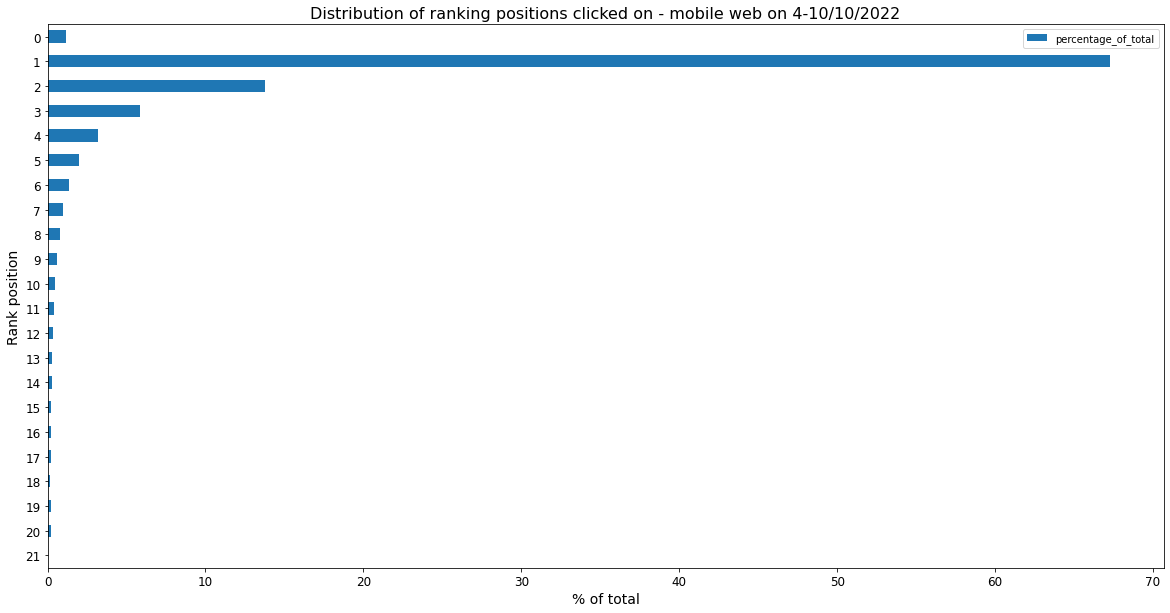

In [24]:
plot_barh(df_distr_click_pos_desktop,"click_position","percentage_of_total","% of total","Rank position","mobile web",2022,10,4,10,(20,10))

### Draft - Plot rank position -> % of clicks with rank pos.

In [ ]:
# without grouping by access method

In [30]:
total_clicks = df_click_pos_amethod_exp.count()
print(total_clicks)

[Stage 32:=====================================================>(255 + 1) / 256]

5475467


In [ ]:
df_click_pos_exp_count = df_click_pos_amethod_exp.select("click_position").groupby("click_position").count()

In [ ]:
df_click_pos_exp_count = df_click_pos_exp_count.withColumn('percentage_of_total',(F.col("count")/total_clicks)*100)

In [ ]:
df_click_pos_exp_count.show(5,False)

In [ ]:
pd_df_click_pos_exp_count = df_click_pos_exp_count.toPandas()

In [ ]:
pd_df_click_pos_exp_count.sort_values(["click_position"], inplace=True, ascending=False)

In [ ]:
pd_df_click_pos_exp_count.plot.barh(x="click_position", y="percentage_of_total", figsize=(20, 10))
plt.title(f"Distribution of ranking positions clicked on - all on {4}-{4+6}/{10}/{2022}",fontsize=16)
plt.xlabel("% of total",fontsize=14)
plt.ylabel("Rank position",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/home/bscarone/search-metrics/clicks-rank/outputs/extensions/barh_click_position_percentage_of_total_all_4-10102022.pdf')

In [ ]:
pd_df_click_pos_exp_count.show(25,False)

In [ ]:
# grouping by access method

In [ ]:
# desktop

In [ ]:
df_click_pos_amethod_exp_desktop = df_click_pos_amethod_exp.select("*").where(F.col("access_method")=="desktop")

In [ ]:
total_clicks_desktop = df_click_pos_amethod_exp_desktop.count()
print(total_clicks_desktop)

In [ ]:
df_click_pos_amethod_exp_count_desktop = df_click_pos_amethod_exp_count_desktop.withColumn('percentage_of_total',(F.col("count")/total_clicks)*100)

In [ ]:
df_click_pos_amethod_exp_count = df_click_pos_amethod_exp.select("click_position","access_method").groupby("click_position","access_method").count()

In [ ]:
df_click_pos_all_exp_count = df_click_pos_amethod_exp.select("click_position").groupby("click_position").count()

### Draft -- Plot: Avg. click rank vs TTFC

In [ ]:
# df_avgrank_ttfc_amethod.select("access_method","avg_rank","ttfc").toPandas().plot.scatter(x='avg_rank', y='ttfc', alpha=0.3, figsize=(20, 10))
df_avgrank_ttfc_amethod.select("access_method","avg_rank","ttfc").toPandas().plot.scatter(x='avg_rank', y='ttfc', alpha=0.3, figsize=(20, 10))
access_method = "desktop"
day = 4
month = 10
year = 2022
plt.title(f'''Avg. rank clicked on vs TTFC - {access_method} on {day}-{day}/{month}/{year}''', fontsize=16)
plt.ylabel("TTFC (in seconds)", fontsize=14)
plt.ylim(ymin=0)
plt.xlabel("Avg. rank clicked on", fontsize=14)
plt.xlim(xmin=0)

plt.xticks(np.arange(0, 21+1, 1.0), fontsize=14) # paramterize according to values of df_avgrank_ttfc_amethod.avg_rank


---------------------

# Rest from previous file

In [ ]:
# rename folder
def hdfs_rename(old_path, new_path):
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    fs.rename(
        spark._jvm.org.apache.hadoop.fs.Path(old_path),
        spark._jvm.org.apache.hadoop.fs.Path(new_path)
    )
    return True

In [ ]:
# hdfs_rename('clicks-rank/df_sessionid_hits_clicks_mobile web_avgrank_4-1072022.parquet','clicks-rank/df_sessionid_hits_clicks_mobile web_avgrank_4-1072022_r182022.parquet')

In [ ]:
avg_rank_by_amethod(2022,7,4,"desktop")

In [ ]:
avg_rank_by_amethod(2022,7,4,"mobile web")

## Tests

In [ ]:
rows = (
    spark.read.table('discovery.query_clicks_daily')
    .where(
        (F.col('year') == 2022) &
        (F.col('month') == 5) &
        (F.col('day') == 18) &
        (F.col('request_set_token') == '1i32cqe4mxbaex28twcc5j5dc')
    )
)

`discovery.query_clicks_daily.hits` contains the search results returned by the search engine

In [ ]:
rows.select('hits').show(1, False)

In [ ]:
rows = (
    spark.read.table('discovery.query_clicks_daily')
    .where(
        (F.col('year') == 2022) &
        (F.col('month') == 5) &
        (F.col('day') == 18) &
        (F.col('request_set_token') == '1i32cqe4mxbaex28twcc5j5dc')
    )
    .select(
        'query', 'hits',
        F.posexplode(F.col('clicks')).alias('click_order', 'click')
    )
    .select(
        'query', 'click_order', 'click',
        F.posexplode(F.col('hits')).alias('hit_position', 'hit')
    )
    .where(F.col('click.pageid') == F.col('hit.pageid'))
    .collect()
)

for row in rows:
    pp = pprint.PrettyPrinter(width=41, compact=True)
    # pp.pprint(row.asDict())
    print(row['click_order'],row['hit_position'])

    print('*' * 20)

In [ ]:
rows2 = (
    spark.read.table('discovery.query_clicks_daily')
    .where(
        (F.col('year') == 2022) &
        (F.col('month') == 5) &
        (F.col('day') == 18) &
        (F.col('request_set_token') == '1i32cqe4mxbaex28twcc5j5dc')
    )
    .withColumn(
        'click_positions', 
         F.expr('transform(clicks.pageid, click_page_id -> array_position(hits.pageid, click_page_id))'))
    .collect()
)
for row in rows2:
    pp.pprint(row['click_positions'])
    print('*' * 20)

In [ ]:
df_clicks_dist = spark.read.parquet("clicks_dist_02-08052022.parquet")

In [ ]:
@F.udf(returnType='float')
def avg_lst(l):
    return F.size(l) #/ len(l)

In [ ]:
df_rank = (
    spark.read.table('discovery.query_clicks_daily')
    .where(
        (F.col('year') == 2022) &
        (F.col('month') == 5) &
        (F.col('day') == 18) 
        # (F.col('request_set_token') == '1i32cqe4mxbaex28twcc5j5dc')
    )
    .withColumn(
        'click_positions', 
         F.expr('transform(clicks.pageid, click_page_id -> array_position(hits.pageid, click_page_id))')
    )# .collect()
    .withColumn(
        "sum_rank", F.expr('aggregate(click_positions, cast(0 as float), (acc, val) -> acc + cast(val as float))')
    )
    .withColumn(
        'avg_rank',
        F.col('sum_rank') / F.size(F.col('click_positions'))
    )
)

In [ ]:
df_rank.select("click_positions","avg_rank").where(F.size(F.col('click_positions')) == 2).show(55,False) #"query","hits","clicks",